In [1]:
#pip install torchvision

In [2]:
import torch 
import torch.autograd as tgrad
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch  import optim

In [3]:
# declaring the option price parameters

S = torch.Tensor([80]).requires_grad_()  # stock price
t = torch.Tensor([0]).requires_grad_()   # time period
sigma = torch.Tensor([0.3]).requires_grad_()   # volatility
r = torch.Tensor([0.05]).requires_grad_()   # interest rate
K  = torch.Tensor([70]) # strike price
T = torch.Tensor([1]) # real time

t2m = T-t # time to maturity

d1 = (torch.log(S/K) + (r + 0.5*sigma**2) * t2m)/(sigma*torch.sqrt(t2m))
d2 = d1 - sigma*torch.sqrt(t2m)

N0 =  lambda value: 0.5*(1+torch.erf((value/2**0.5))) # normal distribution function
Nd1 = N0(d1)
Nd2 = N0(d2)

C = S*Nd1 -K*Nd2*torch.exp(-r*t2m)
pprint(C.item())


17.01496124267578


## Calculating the greeks 

In [4]:
dCdt, =  tgrad.grad(C,t,grad_outputs = torch.ones(C.shape), create_graph = True) # theta
dCdS, = tgrad.grad(C,S,grad_outputs = torch.ones(C.shape), create_graph = True) # delta
d2Cds, = tgrad.grad(dCdS, S,grad_outputs = torch.ones(dCdS.shape) , create_graph= True )
dCdvol, = tgrad.grad(C,sigma, grad_outputs=torch.ones(C.shape), create_graph= True)

dCdr, = tgrad.grad(C,r,grad_outputs = torch.ones(C.shape) ,create_graph = True)
theta , delta, gamma ,vega, rho = -dCdt[0] ,dCdS[0],d2Cds[0],dCdvol[0] ,dCdr[0]

for og in [theta, delta, gamma ,vega, rho]:
    print(f'{og.item():.4f}')


5.8385
0.7769
0.0124
23.8776
45.1372


In [5]:
# Black Scholes Equation.
print((-theta + 0.5*sigma**2*S**2*gamma + r*S*delta - r*C).item())

0.0


Strike price (K) = 40 \
Interest rate (r) = 5% \
Annual volatility of Asset (sigma) = 25%  \
Time to maturity (T) = 1 \
Input ranges for time = [0, 1] and Stock price = [0, 130] \
Instrinsic value of Call Option (gs) = max(Stock Price - K, 0) 

In [12]:
K = 40
r = 0.05
sigma = 0.25
T = 1
S_range = [0, 130]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)


def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)), 
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y = np.zeros((n, 1))
    return X, y

def get_ivp_data(n):
    X = np.concatenate([np.ones((n, 1)),
                    np.random.uniform(*S_range, (n, 1))], axis=1)
    y = gs(X[:, 1]).reshape(-1, 1)
    
    return X, y
  
def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))
    
    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)), 
                        S_range[-1] * np.ones((n, 1))], axis=1)
    y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)
    
    return X1, y1, X2, y2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


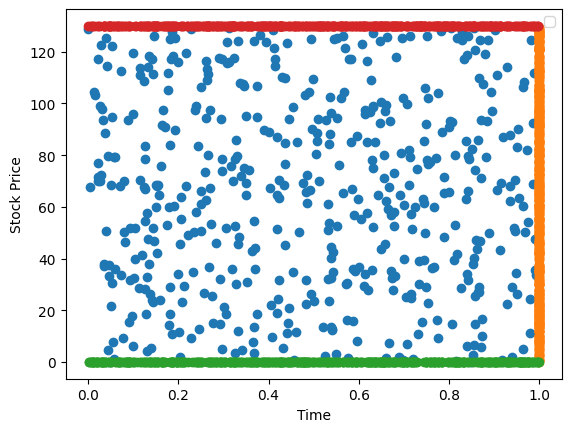

In [17]:
x1,y1 = get_diff_data(500)
x2,y2 = get_ivp_data(500)
x3,y3,x4,y4 = get_bvp_data(500)

plt.scatter(x1[:,0],x1[:,1])
plt.scatter(x2[:,0],x2[:,1])
plt.scatter(x3[:,0],x3[:,1])
plt.scatter(x4[:,0],x4[:,1])
# plt.scatter(x1[:,0],x1[:,1])

plt.xlabel("Time")
plt.ylabel('Stock Price')
plt.legend()

In [18]:
class DGMCell(nn.Module):
  def __init__(self, input_dim, hidden_dim, n_layers=3, output_dim=1):
    super(DGMCell, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.n = n_layers

    self.sig_act = nn.Tanh()

    self.Sw = nn.Linear(self.input_dim, self.hidden_dim)

    self.Uz = nn.Linear(self.input_dim, self.hidden_dim)
    self.Wsz = nn.Linear(self.hidden_dim, self.hidden_dim)

    self.Ug = nn.Linear(self.input_dim, self.hidden_dim)
    self.Wsg = nn.Linear(self.hidden_dim, self.hidden_dim)

    self.Ur = nn.Linear(self.input_dim, self.hidden_dim)
    self.Wsr = nn.Linear(self.hidden_dim, self.hidden_dim)
    
    self.Uh = nn.Linear(self.input_dim, self.hidden_dim)
    self.Wsh = nn.Linear(self.hidden_dim, self.hidden_dim)

    self.Wf = nn.Linear(hidden_dim, output_dim)
    

  def forward(self, x):
    S1 = self.Sw(x)
    for i in range(self.n):
      if i==0:
        S = S1
      else:
        S = self.sig_act(out)
      Z = self.sig_act(self.Uz(x) + self.Wsz(S))
      G = self.sig_act(self.Ug(x) + self.Wsg(S1))
      R = self.sig_act(self.Ur(x) + self.Wsr(S))
      H = self.sig_act(self.Uh(x) + self.Wsh(S*R))
      out = (1-G)*H + Z*S
    out = self.Wf(out)
    return out

model = DGMCell(2, 100, 3, 1)
# model.cuda()

n_epochs = 6000
samples = {"pde": 5000, "bvp":5000, "ivp":5000}
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)
                   

In [19]:
loss_hist = []

for epoch in range(n_epochs):
    
    # PDE Round
    X1, y1 = get_diff_data(samples['pde'])
    X1 = torch.from_numpy(X1).float().requires_grad_()
    y1 = torch.from_numpy(y1).float()
    
    y1_hat = model(X1)
    
    grads = tgrad.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    pde_loss = criterion(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
    
    
    # BVP Round
    X21, y21, X22, y22 = get_bvp_data(samples['bvp'])
    
    X21 = torch.from_numpy(X21).float()
    y21 = torch.from_numpy(y21).float()
    
    X22 = torch.from_numpy(X22).float()
    y22 = torch.from_numpy(y22).float()
    y21_hat = model(X21)
    bvp1_loss = criterion(y21, y21_hat)
    
    y22_hat = model(X22)
    bvp2_loss = criterion(y22, y22_hat)
    
    
    # IVP Round
    X3, y3 = get_ivp_data(samples['ivp'])
    
    X3 = torch.from_numpy(X3).float()
    y3 = torch.from_numpy(y3).float()
    
    y3_hat = model(X3)
    ivp_loss = criterion(y3, y3_hat)
    
    # Backpropagation and Update
    optimizer.zero_grad()
    combined_loss = pde_loss + bvp1_loss + bvp2_loss + ivp_loss
    combined_loss.backward()
    optimizer.step()
    
    loss_hist.append(combined_loss.item())
    if epoch % 500 == 0:
        print(f'{epoch}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BVP1 Loss: {bvp1_loss.item():.5f}, BVP2 Loss: {bvp2_loss.item():.5f}, IVP Loss: {ivp_loss.item():.5f},')
    

0/6000 PDE Loss: 0.02801, BVP1 Loss: 0.05283, BVP2 Loss: 8389.23242, IVP Loss: 1851.82495,
